
# Network Traffic Anomaly Detection - Feature Engineering

## Project Overview

## **Goal:** Engineer features from multivariate time series network data to predict bandwidth anomalies 30 minutes in the future.


### Key Metrics Collected
1. **Bandwidth In/Out** - Network traffic (Mbps)
2. **Packet Loss** - Data transmission quality (%)
3. **CPU/Memory Usage** - Server resources (%)
4. **Active Connections** - Network load (thousands)
5. **DNS Queries** - Domain requests (req/sec)
6. **HTTP Requests** - Web traffic (req/sec)
7. **Failed Connections** - Connection errors (per 5 min)
8. **Latency** - Response time (ms)
9. **Temperature** - Server room temp (Celcius)

In [1]:
# Core imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("NETWORK TRAFFIC ANOMALY DETECTION - FEATURE ENGINEERING")
print("=" * 80)
print("All libraries imported successfully\n")

# Create output directory
os.makedirs('network_data', exist_ok=True)
print("Output directory 'network_data' created")

NETWORK TRAFFIC ANOMALY DETECTION - FEATURE ENGINEERING
All libraries imported successfully

Output directory 'network_data' created


## Section 1: Synthetic Data Generation

We'll generate realistic network metrics with:
- **Daily patterns** (higher traffic during business hours 9-17)
- **Weekly patterns** (lower traffic on weekends)
- **Anomalies** (random spikes ~2% of the time)
- **Noise** (realistic measurement variability)
- **Trend** (gradual increase/decrease over time)

This approach ensures:
1. Data is reproducible (seed=42)
2. No copyright issues (synthetic)
3. Realistic patterns for testing algorithms
4. Complete control over data characteristics

In [12]:
print("\n" + "=" * 80)
print("STEP 1: GENERATING SYNTHETIC NETWORK DATA")
print("=" * 80)

np.random.seed(42)  # Reproducibility

# Time configuration
start_date = datetime(2023, 1, 1, 0, 0, 0)
num_samples = 8640  # 30 days * 288 samples/day (5-minute intervals)
time_index = [start_date + timedelta(minutes=5*i) for i in range(num_samples)]

print(f"\n Generating {num_samples:,} network samples...")
print(f"   Date range: {time_index[0]} to {time_index[-1]}")
print(f"   Collection interval: 5 minutes")

def generate_network_metric(
    base_value=100, trend=0.0, daily_pattern=True, anomalies=True, noise=0.3,
    anomaly_frequency=0.05,  # NEW: Control how often anomalies occur (5% instead of 2%)
    anomaly_magnitude=3.0     # NEW: Control how severe anomalies are
):
    """
    Enhanced version with more control over anomalies

    Parameters:
    -----------
    base_value : float - Base metric value
    trend : float - Linear trend over time
    daily_pattern : bool - Include daily business hour patterns
    anomalies : bool - Include anomalies
    noise : float - Random noise level
    anomaly_frequency : float - Probability of anomaly at each time point (0.05 = 5%)
    anomaly_magnitude : float - Maximum multiplier for anomalies (3.0 = up to 3x normal)
    """
    values = []

    for i in range(len(time_index)):
        value = base_value + (i * trend)

        # Daily pattern with configurable amplitude
        if daily_pattern:
            hour = time_index[i].hour
            day_load = time_index[i].weekday()

            if day_load < 5:  # Business hours
                if 9 <= hour <= 17:
                    value *= 1.8
                else:
                    value *= 0.6
            else:  # Weekend (FIXED)
                value *= 0.4

        # Anomaly spikes with configurable frequency and magnitude
        if anomalies and np.random.random() < anomaly_frequency:
            value *= np.random.uniform(1.5, anomaly_magnitude)

        # Add noise
        noise_value = np.random.normal(0, noise)
        value = max(0, value * (1 + noise_value))
        values.append(value)

    return pd.Series(values, index=time_index)


# Generate all network metrics
print("\nGenerating individual metrics:")
metrics = {}

# FIXED: Removed duplicate Bandwidth_In definition
metrics['Bandwidth_In'] = generate_network_metric(
    base_value=500, trend=0.5, daily_pattern=True, anomalies=True, noise=0.3,
    anomaly_frequency=0.05,  # 5% of time points will have anomalies
    anomaly_magnitude=3.5    # Anomalies will be 1.5x to 3.5x normal value
)
print(" Bandwidth In (Mbps)")

metrics['Bandwidth_Out'] = generate_network_metric(
    base_value=300, trend=0.05, daily_pattern=True, anomalies=True, noise=0.15
)
print("  Bandwidth Out (Mbps)")

metrics['Packet_Loss'] = generate_network_metric(
    base_value=0.5, trend=0.0, daily_pattern=False, anomalies=True, noise=0.3
)
print(" Packet Loss (%)")

metrics['CPU_Usage'] = generate_network_metric(
    base_value=40, trend=0.05, daily_pattern=True, anomalies=False, noise=0.2
)
print(" CPU Usage (%)")

metrics['Memory_Usage'] = generate_network_metric(
    base_value=60, trend=0.08, daily_pattern=True, anomalies=False, noise=0.1
)
print(" Memory Usage (%)")

metrics['Active_Connections'] = generate_network_metric(
    base_value=2.5, trend=0.15, daily_pattern=True, anomalies=True, noise=0.2
)
print(" Active Connections (thousands)")

metrics['DNS_Queries'] = generate_network_metric(
    base_value=1200, trend=0.2, daily_pattern=True, anomalies=True, noise=0.25
)
print(" DNS Queries (requests/sec)")

metrics['HTTP_Requests'] = generate_network_metric(
    base_value=8000, trend=0.3, daily_pattern=True, anomalies=True, noise=0.2
)
print(" HTTP Requests (requests/sec)")

metrics['Failed_Connections'] = generate_network_metric(
    base_value=3, trend=0.01, daily_pattern=False, anomalies=True, noise=0.4
)
print(" Failed Connections (per 5 min)")

metrics['Latency'] = generate_network_metric(
    base_value=45, trend=0.05, daily_pattern=True, anomalies=True, noise=0.2
)
print(" Latency (milliseconds)")

metrics['Temperature'] = generate_network_metric(
    base_value=22, trend=0.01, daily_pattern=True, anomalies=False, noise=0.1
)
print(" Temperature (°C)")

# Create DataFrame
df = pd.DataFrame(metrics, index=time_index)
df.index.name = 'Timestamp'

print(f"\n Data generated successfully!")
print(f"   Shape: {df.shape}")

print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nBasic Statistics:")
print(df.describe())

# Save raw data
df.to_csv('network_data/raw_network_metrics.csv')
print("\n Saved: 'network_data/raw_network_metrics.csv'")


STEP 1: GENERATING SYNTHETIC NETWORK DATA

 Generating 8,640 network samples...
   Date range: 2023-01-01 00:00:00 to 2023-01-30 23:55:00
   Collection interval: 5 minutes

Generating individual metrics:
 Bandwidth In (Mbps)
  Bandwidth Out (Mbps)
 Packet Loss (%)
 CPU Usage (%)
 Memory Usage (%)
 Active Connections (thousands)
 DNS Queries (requests/sec)
 HTTP Requests (requests/sec)
 Failed Connections (per 5 min)
 Latency (milliseconds)
 Temperature (°C)

 Data generated successfully!
   Shape: (8640, 11)

First 5 rows:
                     Bandwidth_In  Bandwidth_Out  Packet_Loss  CPU_Usage  \
Timestamp                                                                  
2023-01-01 00:00:00    133.287193      93.708431     0.376865  14.839108   
2023-01-01 00:05:00    219.353265     122.268346     0.454792  15.992731   
2023-01-01 00:10:00    217.175962     153.867557     0.575420  14.293967   
2023-01-01 00:15:00    261.412810     119.988402     0.411941  19.348706   
2023-01-01 00:

## Section 2: Exploratory Data Analysis (EDA)

Before engineering features, we analyze the raw data:

### What we're looking for:
1. **Temporal patterns** - Are there daily/weekly cycles?
2. **Anomalies** - Spikes or unusual behavior?
3. **Correlations** - Which metrics are related?
4. **Trends** - Is data increasing or decreasing?
5. **Stationarity** - Do patterns change over time?


STEP 2: EXPLORATORY DATA ANALYSIS


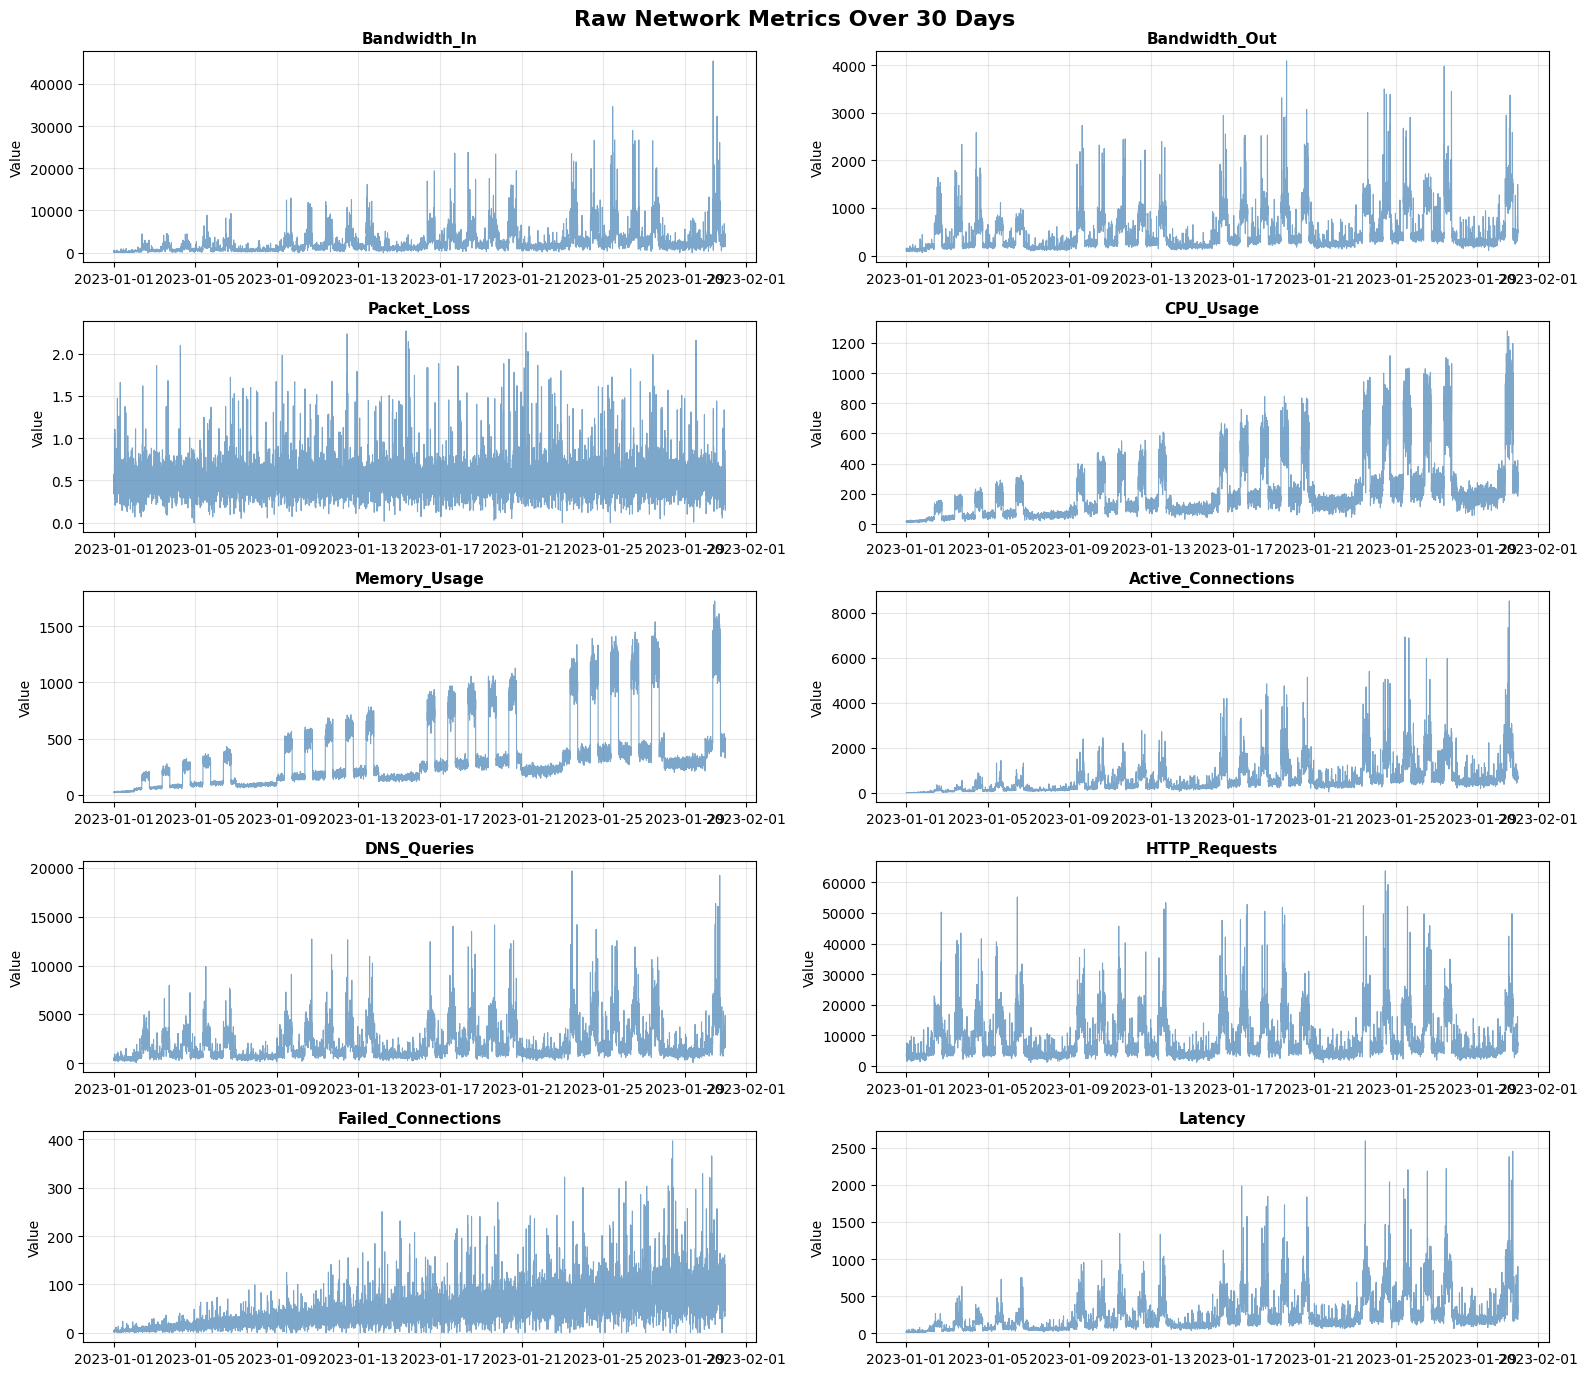


 Saved: '01_raw_metrics.png'


In [13]:


print("\n" + "=" * 80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Plot 1: Raw metrics over time
fig, axes = plt.subplots(5, 2, figsize=(16, 14))
fig.suptitle('Raw Network Metrics Over 30 Days', fontsize=16, fontweight='bold')

for idx, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    ax.plot(df.index, df[col], linewidth=0.8, alpha=0.7, color='steelblue')
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('network_data/01_raw_metrics.png', dpi=100, bbox_inches='tight')
plt.show()
print("\n Saved: '01_raw_metrics.png'")


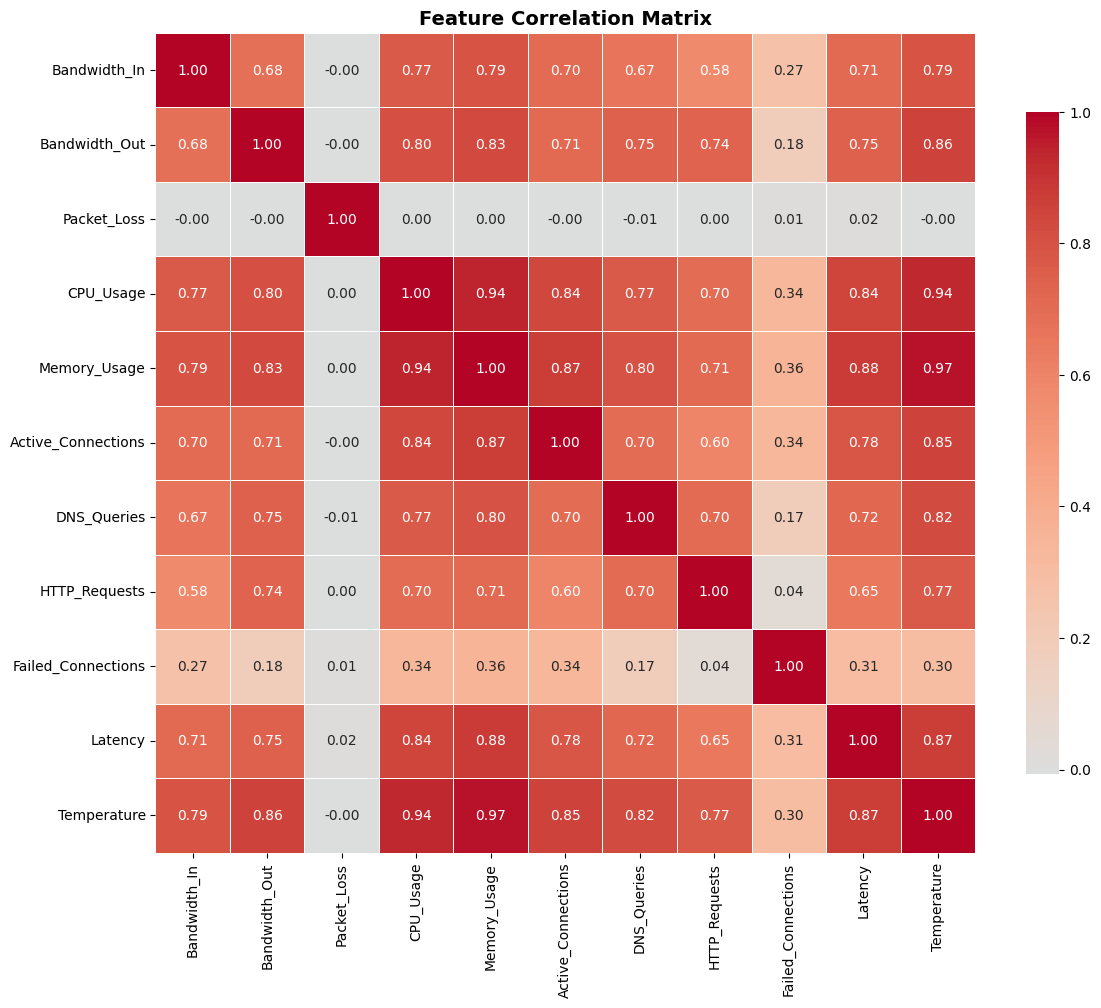

 Saved: '02_correlation_matrix.png'

 Observations:
   - Business hours show higher bandwidth and CPU usage
   - Weekends show much lower network traffic
   - Some metrics are highly correlated


In [14]:
# Plot 2: Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('network_data/02_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print(" Saved: '02_correlation_matrix.png'")

print("\n Observations:")
print("   - Business hours show higher bandwidth and CPU usage")
print("   - Weekends show much lower network traffic")
print("   - Some metrics are highly correlated")


## Section 3: Feature Engineering

Creating new features from raw data to help the model learn better patterns.

### Types of features created:

**1. Domain Features** (from domain knowledge)
- Traffic_Ratio: Relationship between inbound and outbound traffic
- Network_Stress: Weighted combination of system stress indicators
- Request_Efficiency: How many requests per unit latency
- Connection_Health: Inverse of connection failure rate

**2. Temporal Features** (time-based patterns)
- Hour_sin, Hour_cos: Cyclic encoding of hour (0-23)
- DayOfWeek_sin, DayOfWeek_cos: Cyclic encoding of day (0-6)
- Month_sin, Month_cos: Cyclic encoding of month (1-12)
- Is_Business_Hours: Binary indicator for 9-17 weekdays
- Is_Weekend: Binary indicator for Saturday/Sunday

**3. Statistical Features** (historical context)
- Moving averages (30 min, 1 hour, 2 hour windows)
- Rate of change: CPU_Change, Memory_Change, Bandwidth_Change

**Why these features?**
- **Domain features**: Capture real-world relationships
- **Temporal features**: Models learn recurring daily/weekly patterns
- **Statistical features**: Give context of recent history and trends


In [15]:

print("\n" + "=" * 80)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 80)

df_engineered = df.copy()

print("\n Creating domain-specific features:")

# 1. Traffic intensity ratio
df_engineered['Traffic_Ratio'] = df['Bandwidth_In'] / (df['Bandwidth_Out'] + 1)
print("   Traffic_Ratio = Bandwidth_In / Bandwidth_Out")

# 2. Network stress indicator (weighted combination)
df_engineered['Network_Stress'] = (
    (df['CPU_Usage'] / 100) * 0.3 +
    (df['Memory_Usage'] / 100) * 0.3 +
    (df['Packet_Loss'] / 10) * 0.2 +
    (df['Failed_Connections'] / 10) * 0.2
)
print("   Network_Stress (weighted CPU, Memory, Packet Loss, Failures)")

# 3. Request efficiency
df_engineered['Request_Efficiency'] = (
    df['HTTP_Requests'] / (df['Latency'] + 1)
)
print("   Request_Efficiency = HTTP_Requests / Latency")

# 4. Connection health
df_engineered['Connection_Health'] = (
    (1 - (df['Failed_Connections'] / (df['Active_Connections']*100 + 1))) * 100
)
print("   ✓ Connection_Health (inverse of failure rate)")

print("\n Creating temporal features:")

# Extract time components
hour = df.index.hour
day_of_week = df.index.dayofweek
month = df.index.month

# Cyclic encoding of time
df_engineered['Hour_sin'] = np.sin(2 * np.pi * hour / 24)
df_engineered['Hour_cos'] = np.cos(2 * np.pi * hour / 24)
print("   Hour_sin, Hour_cos (cyclic hour: 0-23)")

df_engineered['DayOfWeek_sin'] = np.sin(2 * np.pi * day_of_week / 7)
df_engineered['DayOfWeek_cos'] = np.cos(2 * np.pi * day_of_week / 7)
print("   DayOfWeek_sin, DayOfWeek_cos (cyclic day: 0-6)")

df_engineered['Month_sin'] = np.sin(2 * np.pi * month / 12)
df_engineered['Month_cos'] = np.cos(2 * np.pi * month / 12)
print("   Month_sin, Month_cos (cyclic month: 1-12)")

# Binary indicators
df_engineered['Is_Business_Hours'] = ((hour >= 9) & (hour < 17) & (day_of_week < 5)).astype(float)
print("    Is_Business_Hours (1 if 9-17 weekday, else 0)")

df_engineered['Is_Weekend'] = (day_of_week >= 5).astype(float)
print("    Is_Weekend (1 if Sat/Sun, else 0)")

print("\n Creating rolling statistics:")

# Rolling averages (moving windows)
for window in [6, 12, 24]:  # 30 min, 1 hour, 2 hours
    df_engineered[f'Bandwidth_In_MA{window}'] = df['Bandwidth_In'].rolling(window=window, min_periods=1).mean()
    df_engineered[f'CPU_Usage_MA{window}'] = df['CPU_Usage'].rolling(window=window, min_periods=1).mean()
    print(f"    Moving averages (window={window} = {window*5} minutes)")

print("\n Creating rate-of-change features:")

# Rate of change (derivatives)
df_engineered['CPU_Change'] = df['CPU_Usage'].diff().fillna(0)
df_engineered['Memory_Change'] = df['Memory_Usage'].diff().fillna(0)
df_engineered['Bandwidth_Change'] = df['Bandwidth_In'].diff().fillna(0)
print("    CPU_Change, Memory_Change, Bandwidth_Change")

print(f"\n Feature engineering complete!")
print(f"   Original features: {len(df.columns)}")
print(f"   Engineered features: {len(df_engineered.columns)}")
print(f"   New features added: {len(df_engineered.columns) - len(df.columns)}")

print(f"\nAll engineered features ({len(df_engineered.columns)}):")
for i, col in enumerate(df_engineered.columns, 1):
    print(f"   {i:2d}. {col}")



STEP 3: FEATURE ENGINEERING

 Creating domain-specific features:
   Traffic_Ratio = Bandwidth_In / Bandwidth_Out
   Network_Stress (weighted CPU, Memory, Packet Loss, Failures)
   Request_Efficiency = HTTP_Requests / Latency
   ✓ Connection_Health (inverse of failure rate)

 Creating temporal features:
   Hour_sin, Hour_cos (cyclic hour: 0-23)
   DayOfWeek_sin, DayOfWeek_cos (cyclic day: 0-6)
   Month_sin, Month_cos (cyclic month: 1-12)
    Is_Business_Hours (1 if 9-17 weekday, else 0)
    Is_Weekend (1 if Sat/Sun, else 0)

 Creating rolling statistics:
    Moving averages (window=6 = 30 minutes)
    Moving averages (window=12 = 60 minutes)
    Moving averages (window=24 = 120 minutes)

 Creating rate-of-change features:
    CPU_Change, Memory_Change, Bandwidth_Change

 Feature engineering complete!
   Original features: 11
   Engineered features: 32
   New features added: 21

All engineered features (32):
    1. Bandwidth_In
    2. Bandwidth_Out
    3. Packet_Loss
    4. CPU_Usage
  


## Section 4: Data Normalization

**Why normalize?**
- Neural networks perform better with scaled inputs (0-1 or -1 to 1)
- Prevents features with large ranges from dominating
- Faster convergence during training
- Improves model stability

**Method: Min-Max Scaling**
$$\text{Normalized} = \frac{x - \min(x)}{\max(x) - \min(x)}$$

Result: All values mapped to [0, 1] range


In [16]:

print("\n" + "=" * 80)
print("STEP 4: DATA NORMALIZATION")
print("=" * 80)

# Use MinMax scaler to normalize to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_engineered),
    columns=df_engineered.columns,
    index=df_engineered.index
)

print("\n Applied MinMaxScaler to all features")
print(f"   Range: [0, 1]")
print(f"   Formula: (x - min) / (max - min)")

print(f"\nNormalized data shape: {df_normalized.shape}")
print(f"   Rows: {df_normalized.shape[0]:,} (samples)")
print(f"   Cols: {df_normalized.shape[1]} (features)")

print(f"\nMin/Max verification:")
print(f"   Min value: {df_normalized.values.min():.4f}")
print(f"   Max value: {df_normalized.values.max():.4f}")

print(f"\nFirst row of normalized data:")
print(df_normalized.iloc[0])

# Save processed data
df_normalized.to_csv('network_data/processed_network_metrics.csv')
print(f"\n Saved: 'network_data/processed_network_metrics.csv'")



STEP 4: DATA NORMALIZATION

 Applied MinMaxScaler to all features
   Range: [0, 1]
   Formula: (x - min) / (max - min)

Normalized data shape: (8640, 32)
   Rows: 8,640 (samples)
   Cols: 32 (features)

Min/Max verification:
   Min value: 0.0000
   Max value: 1.0000

First row of normalized data:
Bandwidth_In          0.002934
Bandwidth_Out         0.008061
Packet_Loss           0.166049
CPU_Usage             0.004633
Memory_Usage          0.000926
Active_Connections    0.000000
DNS_Queries           0.017820
HTTP_Requests         0.043194
Failed_Connections    0.009519
Latency               0.003303
Temperature           0.008000
Traffic_Ratio         0.040170
Network_Stress        0.004988
Request_Efficiency    0.335059
Connection_Health     0.273476
Hour_sin              0.500000
Hour_cos              1.000000
DayOfWeek_sin         0.099031
DayOfWeek_cos         0.801938
Month_sin             0.000000
Month_cos             0.000000
Is_Business_Hours     0.000000
Is_Weekend         


## Section 5: Visualizing Engineered Features

Verify the engineered features look reasonable and capture expected patterns.




STEP 5: VISUALIZING ENGINEERED FEATURES


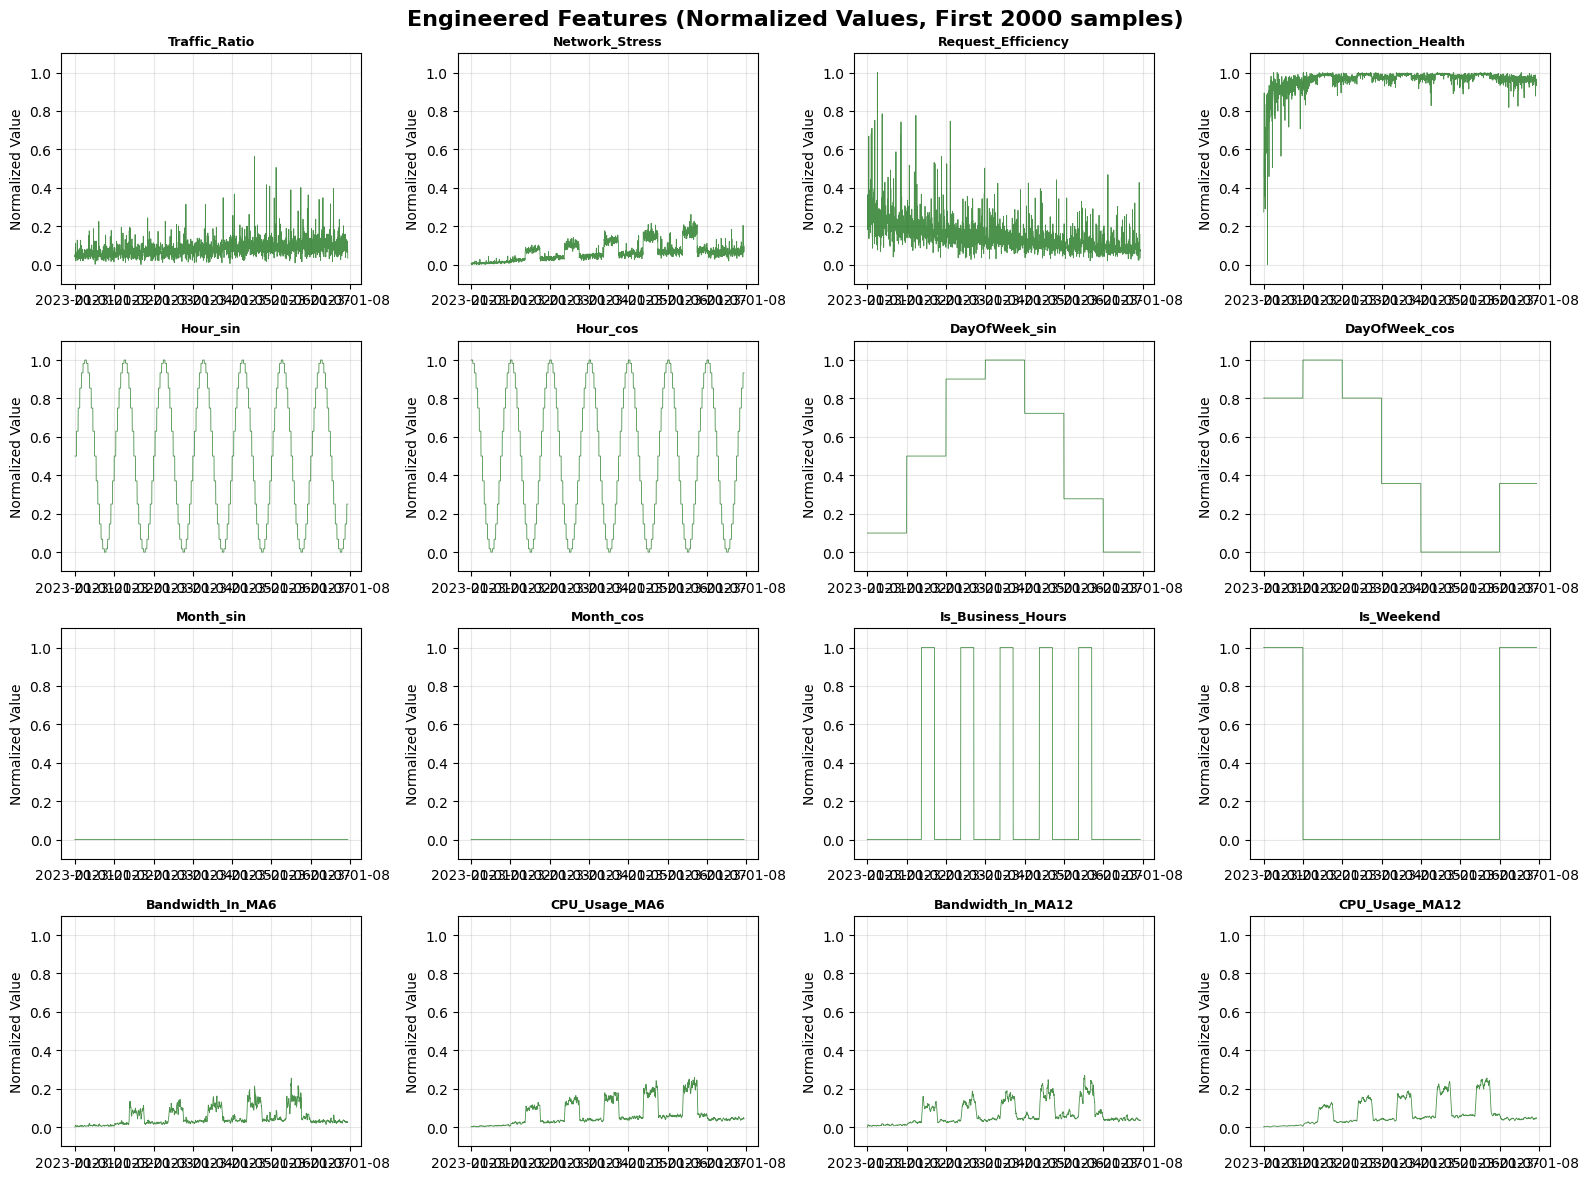


 Saved: '03_engineered_features.png'

 Feature patterns observed:
    Hour_sin/Hour_cos: Smooth cyclic patterns (daily)
   DayOfWeek_sin/cos: Weekly patterns
   Moving averages: Smoother than raw data
   Rate of change: Spiky, shows volatility


In [17]:
# CODE CELL 6: VISUALIZE ENGINEERED FEATURES

print("\n" + "=" * 80)
print("STEP 5: VISUALIZING ENGINEERED FEATURES")
print("=" * 80)

# Extract only newly engineered features
engineered_cols = [col for col in df_engineered.columns if col not in df.columns]

# Plot first 16 engineered features
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle('Engineered Features (Normalized Values, First 2000 samples)',
             fontsize=16, fontweight='bold')

for idx, col in enumerate(engineered_cols[:16]):
    ax = axes[idx // 4, idx % 4]
    ax.plot(df_normalized[col].iloc[:2000], linewidth=0.6, color='darkgreen', alpha=0.7)
    ax.set_title(col, fontsize=9, fontweight='bold')
    ax.set_ylabel('Normalized Value')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig('network_data/03_engineered_features.png', dpi=100, bbox_inches='tight')
plt.show()
print("\n Saved: '03_engineered_features.png'")

print("\n Feature patterns observed:")
print("    Hour_sin/Hour_cos: Smooth cyclic patterns (daily)")
print("   DayOfWeek_sin/cos: Weekly patterns")
print("   Moving averages: Smoother than raw data")
print("   Rate of change: Spiky, shows volatility")


## Section 6: Train-Test Split

**Important for time series:**
- Don't shuffle! Maintain temporal order
- Train on past data, test on future data
- Prevents data leakage

**Split ratio: 75% train, 25% test**
- Training: First 6480 samples (22.5 days)
- Testing: Last 2160 samples (7.5 days)


In [18]:

print("\n" + "=" * 80)
print("STEP 6: TRAIN-TEST SPLIT")
print("=" * 80)

# 75% train, 25% test (DO NOT SHUFFLE - preserve temporal order)
TRAIN_SIZE = int(len(df_normalized) * 0.75)

train_data = df_normalized.iloc[:TRAIN_SIZE]
test_data = df_normalized.iloc[TRAIN_SIZE:]

print(f"\nTrain-Test Split (no shuffling - temporal order preserved):")
print(f"   Total records: {len(df_normalized):,}")
print(f"   Train set: {len(train_data):,} ({len(train_data)/len(df_normalized)*100:.1f}%)")
print(f"   Test set: {len(test_data):,} ({len(test_data)/len(df_normalized)*100:.1f}%)")

print(f"\nTrain date range: {df_normalized.index[0]} to {df_normalized.index[TRAIN_SIZE-1]}")
print(f"Test date range: {df_normalized.index[TRAIN_SIZE]} to {df_normalized.index[-1]}")

# Save splits
train_data.to_csv('network_data/train_data.csv')
test_data.to_csv('network_data/test_data.csv')
print(f"\n Saved: 'network_data/train_data.csv'")
print(f"Saved: 'network_data/test_data.csv'")


STEP 6: TRAIN-TEST SPLIT

Train-Test Split (no shuffling - temporal order preserved):
   Total records: 8,640
   Train set: 6,480 (75.0%)
   Test set: 2,160 (25.0%)

Train date range: 2023-01-01 00:00:00 to 2023-01-23 11:55:00
Test date range: 2023-01-23 12:00:00 to 2023-01-30 23:55:00

 Saved: 'network_data/train_data.csv'
Saved: 'network_data/test_data.csv'



## Section 7: Creating Time Series Windows

**Why windowing?**
- LSTM models need sequence inputs
- Can't train on individual data points
- Need context (history) → predict future

**Window structure:**
```
History Window (24 timesteps = 2 hours)    |   Prediction Target
[t-24, t-23, ..., t-2, t-1] → Predict [t+6]
5min  5min  ...  5min  5min     30 min ahead
```

**Parameters:**
- **History steps:** 24 timesteps = 120 minutes = 2 hours
- **Forecast steps:** 6 timesteps = 30 minutes ahead
- **Stride:** 1 (move window by 1 sample each time)


In [19]:
print("\n" + "=" * 80)
print("STEP 7: CREATING TIME SERIES WINDOWS")
print("=" * 80)

def create_time_windows(data, history_steps=24, forecast_steps=6, stride=1):
    """
    Create sliding windows for time series prediction (LSTM input).

    Args:
        data: Normalized dataframe (samples × features)
        history_steps: Number of past timesteps (sequence length)
        forecast_steps: Steps ahead to predict
        stride: Step size between consecutive windows

    Returns:
        X: Windows of features (n_windows, history_steps, n_features)
        y: Target values (n_windows, 1)
    """
    X, y = [], []

    # Total window needed: history + forecast
    total_window_size = history_steps + forecast_steps

    # Generate sliding windows
    for i in range(0, len(data) - total_window_size + 1, stride):
        # Get historical window (features)
        window_x = data.iloc[i:i+history_steps].values
        X.append(window_x)

        # Get target (future value of first metric: Bandwidth_In)
        future_idx = i + history_steps + forecast_steps - 1
        future_value = data.iloc[future_idx, 0]  # First column
        y.append(future_value)

    return np.array(X), np.array(y)

# Window parameters
HISTORY_STEPS = 24      # 120 minutes (2 hours)
FORECAST_STEPS = 6      # 30 minutes ahead
STRIDE = 1              # Move by 1 sample

print(f"\n Window Parameters:")
print(f"   History (lookback): {HISTORY_STEPS} timesteps")
print(f"                     = {HISTORY_STEPS * 5} minutes (~2 hours)")
print(f"   Forecast horizon:   {FORECAST_STEPS} timesteps")
print(f"                     = {FORECAST_STEPS * 5} minutes (30 min ahead)")
print(f"   Stride:             {STRIDE} sample(s)")

print(f"\nCreating training windows...")
X_train, y_train = create_time_windows(train_data, HISTORY_STEPS, FORECAST_STEPS, STRIDE)

print(f"Creating test windows...")
X_test, y_test = create_time_windows(test_data, HISTORY_STEPS, FORECAST_STEPS, STRIDE)

print(f"\n Training windows created:")
print(f"   Shape: {X_train.shape}")
print(f"   - Samples: {X_train.shape[0]:,}")
print(f"   - Timesteps (sequence length): {X_train.shape[1]}")
print(f"   - Features (input size): {X_train.shape[2]}")

print(f"\n Test windows created:")
print(f"   Shape: {X_test.shape}")
print(f"   - Samples: {X_test.shape[0]:,}")
print(f"   - Timesteps: {X_test.shape[1]}")
print(f"   - Features: {X_test.shape[2]}")

print(f"\n Ready for LSTM!")
print(f"   Input shape for model:  (None, {HISTORY_STEPS}, {X_train.shape[2]})")
print(f"   Output shape:           (None, 1)")


STEP 7: CREATING TIME SERIES WINDOWS

 Window Parameters:
   History (lookback): 24 timesteps
                     = 120 minutes (~2 hours)
   Forecast horizon:   6 timesteps
                     = 30 minutes (30 min ahead)
   Stride:             1 sample(s)

Creating training windows...
Creating test windows...

 Training windows created:
   Shape: (6451, 24, 32)
   - Samples: 6,451
   - Timesteps (sequence length): 24
   - Features (input size): 32

 Test windows created:
   Shape: (2131, 24, 32)
   - Samples: 2,131
   - Timesteps: 24
   - Features: 32

 Ready for LSTM!
   Input shape for model:  (None, 24, 32)
   Output shape:           (None, 1)



## Section 8: Saving Processed Data

Saving windowed arrays as NumPy files for easy loading in model training.

**Files created:**
- `X_train.npy` - Training input sequences
- `y_train.npy` - Training targets
- `X_test.npy` - Test input sequences  
- `y_test.npy` - Test targets


In [20]:

print("\n" + "=" * 80)
print("STEP 8: SAVING WINDOWED DATA")
print("=" * 80)

# Save as numpy arrays
np.save('network_data/X_train.npy', X_train)
np.save('network_data/y_train.npy', y_train)
np.save('network_data/X_test.npy', X_test)
np.save('network_data/y_test.npy', y_test)

print("\n✓ Saved numpy arrays to network_data/ folder:")
print(f"   • X_train.npy - ({X_train.shape})")
print(f"   • y_train.npy - ({y_train.shape})")
print(f"   • X_test.npy  - ({X_test.shape})")
print(f"   • y_test.npy  - ({y_test.shape})")

print(f"\n All files ready for model training!")



STEP 8: SAVING WINDOWED DATA

✓ Saved numpy arrays to network_data/ folder:
   • X_train.npy - ((6451, 24, 32))
   • y_train.npy - ((6451,))
   • X_test.npy  - ((2131, 24, 32))
   • y_test.npy  - ((2131,))

 All files ready for model training!



## Section 9: Final Verification & Summary

Inspect the first window to verify structure is correct.


In [21]:

print("\n" + "=" * 80)
print("STEP 9: FINAL VERIFICATION")
print("=" * 80)

print(f"\n Sample Window Inspection (First Training Example):")
print(f"\nWindow structure:")
print(f"   X_train[0] shape: {X_train[0].shape}")
print(f"   - {X_train[0].shape[0]} timesteps (2 hour history)")
print(f"   - {X_train[0].shape[1]} features (all engineered)")

print(f"\nFirst timestep of first window (all features):")
first_window = X_train[0][0]
for i, col in enumerate(df_normalized.columns):
    print(f"   {i:2d}. {col:25s} = {first_window[i]:.4f}")

print(f"\n Target (prediction):")
print(f"   Predicting: Bandwidth_In value")
print(f"   Time ahead: {FORECAST_STEPS * 5} minutes (30 min)")
print(f"   y_train[0] = {y_train[0]:.4f} (normalized)")

print(f"\n" + "=" * 80)
print("FEATURE ENGINEERING PIPELINE COMPLETE!")
print("=" * 80)

print(f"\n Output files in 'network_data/' folder:")
print(f"\n   CSV Files (for reference):")
print(f"   • raw_network_metrics.csv (original synthetic data)")
print(f"   • processed_network_metrics.csv (after feature engineering)")
print(f"   • train_data.csv (normalized training set)")
print(f"   • test_data.csv (normalized test set)")

print(f"\n   NumPy Arrays (for TensorFlow/Keras):")
print(f"   • X_train.npy ({X_train.shape})")
print(f"   • y_train.npy ({y_train.shape})")
print(f"   • X_test.npy ({X_test.shape})")
print(f"   • y_test.npy ({y_test.shape})")

print(f"\n   Visualizations (PNG):")
print(f"   • 01_raw_metrics.png")
print(f"   • 02_correlation_matrix.png")
print(f"   • 03_engineered_features.png")

print(f"\n Next Steps:")
print(f"   1. Build LSTM model with input shape: ({HISTORY_STEPS}, {X_train.shape[2]})")
print(f"   2. Load data: X_train = np.load('network_data/X_train.npy')")
print(f"   3. Train model on windowed sequences")
print(f"   4. Evaluate on test set")
print(f"   5. Predict future bandwidth anomalies")



STEP 9: FINAL VERIFICATION

 Sample Window Inspection (First Training Example):

Window structure:
   X_train[0] shape: (24, 32)
   - 24 timesteps (2 hour history)
   - 32 features (all engineered)

First timestep of first window (all features):
    0. Bandwidth_In              = 0.0029
    1. Bandwidth_Out             = 0.0081
    2. Packet_Loss               = 0.1660
    3. CPU_Usage                 = 0.0046
    4. Memory_Usage              = 0.0009
    5. Active_Connections        = 0.0000
    6. DNS_Queries               = 0.0178
    7. HTTP_Requests             = 0.0432
    8. Failed_Connections        = 0.0095
    9. Latency                   = 0.0033
   10. Temperature               = 0.0080
   11. Traffic_Ratio             = 0.0402
   12. Network_Stress            = 0.0050
   13. Request_Efficiency        = 0.3351
   14. Connection_Health         = 0.2735
   15. Hour_sin                  = 0.5000
   16. Hour_cos                  = 1.0000
   17. DayOfWeek_sin             = 0.09